In [ ]:
%cd /content/drive/MyDrive/기업연계프로젝트/Datasets
!unzip -qq '/content/drive/MyDrive/기업연계프로젝트/Datasets/Datasets.zip'

/content/drive/MyDrive/기업연계프로젝트/Datasets


In [ ]:
import os

path = "/content/drive/MyDrive/기업연계프로젝트/Datasets/Train/images"
file_list = os.listdir(path)
len(file_list)

635

In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install torchtext
!pip install adamp
!pip install wandb
!pip install torchmetrics

In [ ]:
import os 
import cv2
import torch
import torchvision
import PIL
import wandb
import natsort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.optim.lr_scheduler as lr_scheduler

from adamp import AdamP
from torchmetrics.functional import jaccard_index, accuracy, f1_score, precision, recall
from glob import glob
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
# from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from torchvision.transforms.functional import to_pil_image
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from pytorch_lightning.loggers import WandbLogger

pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [ ]:
image_dir = "/content/drive/MyDrive/기업연계프로젝트/Datasets/Train/images/"
mask_dir = "/content/drive/MyDrive/기업연계프로젝트/Datasets/Train/masks/"

images_paths = glob(image_dir + "*.jpg")
masks_paths = glob(mask_dir + "*.png")

images_paths = natsort.natsorted(images_paths)
masks_paths = natsort.natsorted(masks_paths)
df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
df.head(5)

,images,masks
0,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
1,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
2,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
3,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
4,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...


In [ ]:
test_image_dir = "/content/drive/MyDrive/기업연계프로젝트/Datasets/Test/images/"
test_mask_dir = "/content/drive/MyDrive/기업연계프로젝트/Datasets/Test/masks/"

images_paths = glob(test_image_dir + "*.jpg")
masks_paths = glob(test_mask_dir + "*.png")

images_paths = natsort.natsorted(images_paths)
masks_paths =natsort.natsorted(masks_paths)

test_df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
test_df.head(5)

,images,masks
0,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
1,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
2,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
3,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...
4,/content/drive/MyDrive/기업연계프로젝트/Dat...,/content/drive/MyDrive/기업연계프로젝트/Dat...


In [ ]:
train, valid = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

print(f"Train size: {len(train)}, Validation size: {len(valid)}")

Train size: 571, Validation size: 64


In [ ]:
@interact(index=(0, len(df)-1))
def show_images(index=0):
    image = cv2.imread(df.iloc[index].images)
    mask = cv2.imread(df.iloc[index].masks)

    plt.figure(figsize=(12,10))
    plt.subplot(121)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(122)
    plt.title("mask")
    plt.imshow(mask)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=634), Output()), _dom_classes=('widget-inter…

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
base_transform = [
    # A.Normalize(
    # mean=[0.485, 0.456, 0.406],
    # std=[0.229, 0.224, 0.225],
    # ),
    ToTensorV2()
]

train_transform = [
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, 
                       border_mode=cv2.BORDER_REFLECT, p=0.5), 
    A.RandomRain(brightness_coefficient=0.9, drop_length=10, drop_width=1, blur_value=3, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=1),
    A.CLAHE(clip_limit=2, tile_grid_size=(8, 8), p=1),
    A.RandomCrop(width=320, height=320)
    ]

train_transform.extend(base_transform)
train_transform = A.Compose(train_transform)

test_transform = A.Compose(base_transform)

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index].images
        mask_path = self.df.iloc[index].masks

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0) //255
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image'].float()
            transformed_mask = transformed['mask'].float()
        
        return transformed_image, transformed_mask

In [ ]:
ds = SegmentationDataset(df, train_transform)
test_ds = SegmentationDataset(test_df, test_transform)

In [ ]:
@interact(index=(0, len(df)-1))
def show_images(index=0):
    img, mask = ds[index]
    plt.figure(figsize=(20,10))
    plt.axis=("off")
    plt.subplot(121)
    img = img.int()
    plt.imshow(img.permute(1,2,0))
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')


interactive(children=(IntSlider(value=0, description='index', max=634), Output()), _dom_classes=('widget-inter…

In [ ]:
import torchmetrics
class SegmentationModel(pl.LightningModule):
    def __init__(self, args=None, optimizer='adam', scheduler='reducelr'):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='efficientnet-b0',  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,  # model output channels (number of classes in your dataset)
        )
        self.args = args
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optimizer
        self.scheduler = scheduler

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        if self.optimizer == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        elif self.args.optimizer == 'adamw':
            optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        elif self.args.optimizer == 'adamp':
            optimizer = AdamP(self.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-2)

        if self.scheduler == "reducelr":
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, mode="max", verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val/loss"}

        elif self.args.scheduler == "cosineanneal":
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5,
                                                                 last_epoch=-1, verbose=True)

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, train_batch, batch_idx):
        image, mask = train_batch

        outputs = self.model(image)
        loss = self.criterion(outputs, mask.unsqueeze(0).permute(1,0,2,3))

        # jaccard_index_value = jaccard_index(outputs.argmax(dim=1), mask.long(), num_classes=1)
        acc_value = torchmetrics.functional.accuracy(torch.sigmoid(outputs), mask.long())
        f1_value = torchmetrics.functional.f1_score(torch.sigmoid(outputs), mask.long())
        precision_value = torchmetrics.functional.precision(torch.sigmoid(outputs), mask.long())
        recall_value = torchmetrics.functional.recall(torch.sigmoid(outputs), mask.long())

        self.log('train/loss', loss, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/acc', acc_value, on_epoch=True, on_step=True, prog_bar=True)
        # self.log('train/jaccard_index_value', jaccard_index_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/f1', f1_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/precision', precision_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/recall', recall_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        
        # return {"loss": loss, "acc": acc_value, "jaccard_index": jaccard_index_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}
        return {"loss": loss, "acc": acc_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}

    def validation_step(self, val_batch, batch_idx):
        image, mask = val_batch
        
        outputs = self.model(image)
        loss = self.criterion(outputs, mask.unsqueeze(0).permute(1,0,2,3))

        # jaccard_index_value = jaccard_index(outputs.argmax(dim=1), mask.long(), num_classes=1)
        acc_value = torchmetrics.functional.accuracy(torch.sigmoid(outputs), mask.long())
        f1_value = torchmetrics.functional.f1_score(torch.sigmoid(outputs), mask.long())
        precision_value = torchmetrics.functional.precision(torch.sigmoid(outputs), mask.long())
        recall_value = torchmetrics.functional.recall(torch.sigmoid(outputs), mask.long())

        self.log('val/loss', loss, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('val/acc', acc_value, on_epoch=True, on_step=True, prog_bar=True)
        # self.log('val/jaccard_index_value', jaccard_index_value, on_epoch=True, on_step=True, prog_bar=True,sync_dist=True)
        self.log('val/f1', f1_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('val/precision', precision_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('val/recall', recall_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        

        # return {"loss": loss, "acc": acc_value, "jaccard_index": jaccard_index_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}
        return {"loss": loss, "acc": acc_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}

    def test_step(self, test_batch, batch_idx):
        image, mask = test_batch
        
        outputs = self.model(image)
        loss = self.criterion(outputs, mask.unsqueeze(0).permute(1,0,2,3))

        # jaccard_index_value = jaccard_index(outputs.argmax(dim=1), mask.long(), num_classes=1)
        acc_value = torchmetrics.functional.accuracy(torch.sigmoid(outputs), mask.long())
        f1_value = torchmetrics.functional.f1_score(torch.sigmoid(outputs), mask.long())
        precision_value = torchmetrics.functional.precision(torch.sigmoid(outputs), mask.long())
        recall_value = torchmetrics.functional.recall(torch.sigmoid(outputs), mask.long())

        self.log('test/loss', loss, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/acc', acc_value, on_epoch=True, on_step=False, prog_bar=True)
        # self.log('test/jaccard_index_value', jaccard_index_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/f1', f1_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/precision', precision_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/recall', recall_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)

        # return {"loss": loss, "acc": acc_value, "jaccard_index": jaccard_index_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}
        return {"loss": loss, "acc": acc_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}


In [ ]:
kf = KFold(n_splits=5)
for idx, (train_index, val_index) in enumerate(kf.split(X=train['images'])):
    wandb_logger = WandbLogger(project="BORDER_CONSTANT", name=f'K_5fold{idx + 1:02d}', entity="crack_detection_22")
    checkpoint_callback = ModelCheckpoint(
            monitor="val/loss",
            dirpath="/content/drive/MyDrive/기업연계프로젝트/checkpoints",
            filename=f"K_5fold{idx + 1:02d}_" + "{val/loss:.4f}",
            save_top_k=3,
            mode="min",
            # save_weights_only=True
        )

    early_stop_callback = EarlyStopping(monitor="val/loss", min_delta=0.00, patience=50, verbose=True,
                                            mode="min")
    model = SegmentationModel()

    train_ds = SegmentationDataset(train, train_transform)
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=12, num_workers=2, shuffle=True, drop_last=True)

    valid_ds = SegmentationDataset(valid, train_transform)
    val_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=12, num_workers=2)

    test_ds = SegmentationDataset(test_df, test_transform)
    test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=2)

    trainer = pl.Trainer(accelerator='gpu',
                      devices=1,
                      max_epochs=5,
                      log_every_n_steps=1,
                      logger=wandb_logger,
                      callbacks=[checkpoint_callback, early_stop_callback])
    
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    trainer.test(dataloaders=test_dataloader)

    wandb.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/drive/MyDrive/기업연계프로젝트/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | UnetPlusPlus      | 6.6 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.6 M     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 4.859


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 4.746 >= min_delta = 0.0. New best score: 0.113


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.051 >= min_delta = 0.0. New best score: 0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.016 >= min_delta = 0.0. New best score: 0.046


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.043
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold01_val/loss=0.0430.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /conte

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9787825345993042
         test/f1            0.5809805989265442
        test/loss           0.06207340583205223
     test/precision         0.6126543879508972
       test/recall          0.6100144982337952
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁████
train/acc_step,▁▂▇█████████████████████████████████████
train/f1_epoch,▁▆▇██
train/f1_step,▁▁▄▄▆▇▇▇▆▇▇▇▇▇█▇▇▆▇▆▇█▆▅█▇▇▇█▇▇█▇▇███▇▇▇
train/loss_epoch,█▂▁▁▁


wandb: Currently logged in as: leehm (crack_detection_22). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | UnetPlusPlus      | 6.6 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.278    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 2.151


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 2.016 >= min_delta = 0.0. New best score: 0.135


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.072 >= min_delta = 0.0. New best score: 0.063


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.040


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold02_val/loss=0.0398.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold02_val/loss=0.0398.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9809762835502625
         test/f1            0.5144610404968262
        test/loss           0.06092892959713936
     test/precision         0.7649163007736206
       test/recall          0.43168142437934875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████▆
test/acc,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁▇███
train/acc_step,▁▆█████████▇████████████████████████████
train/f1_epoch,▁▆▇██
train/f1_step,▁▃▆▆▆▇▄▅▇▇█▆▇▆▇▇▇▇█▇▇█▇█▇▇▇▇▆▇▇▇▇▆▇▆▇█▇█
train/loss_epoch,█▂▁▁▁


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | UnetPlusPlus      | 6.6 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.278    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 3.200


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 3.094 >= min_delta = 0.0. New best score: 0.106


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.029 >= min_delta = 0.0. New best score: 0.077


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.032 >= min_delta = 0.0. New best score: 0.045
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold03_val/loss=0.0448.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold03_val/loss=0.0448.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9805769324302673
         test/f1            0.6021140217781067
        test/loss           0.05679982528090477
     test/precision         0.6735057830810547
       test/recall          0.5932894349098206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁████
train/acc_step,▁▃▇█████████████████████████████████████
train/f1_epoch,▁▇▇▇█
train/f1_step,▁▂▄▅▇▇▆▇▇▆▆▇▆▆▇▆▇▇▇▇▆█▇▇▇▆▆█▇▆▇▇▆▇▇▇▆▇█▇
train/loss_epoch,█▂▁▁▁


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | UnetPlusPlus      | 6.6 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.278    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 2.348


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 2.261 >= min_delta = 0.0. New best score: 0.086


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.037 >= min_delta = 0.0. New best score: 0.049


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.045
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold04_val/loss=0.0454.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold04_val/loss=0.0454.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9779927730560303
         test/f1            0.6115383505821228
        test/loss           0.06040295585989952
     test/precision         0.6103726029396057
       test/recall          0.7121264934539795
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁████
train/acc_step,▁▅██████████████████████████████████████
train/f1_epoch,▁▆▇██
train/f1_step,▁▂▅▆▆▆▆▇▆▅▆▆▆▆▆█▇▆▆▇█▇▇▆▆▇▆▇▆█▇█▇▇▇▇▇▇█▇
train/loss_epoch,█▂▁▁▁


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | UnetPlusPlus      | 6.6 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.278    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 2.677


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 2.600 >= min_delta = 0.0. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.022 >= min_delta = 0.0. New best score: 0.055


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.047
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold05_val/loss=0.0466.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold05_val/loss=0.0466.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9779941439628601
         test/f1            0.6045551896095276
        test/loss           0.06752098351716995
     test/precision         0.5854762196540833
       test/recall          0.6903764009475708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁████
train/acc_step,▁▅▇█████████████████████████████████████
train/f1_epoch,▁▆▇██
train/f1_step,▁▂▄▆▅▆▆▆▆▆▆▅▇▆▇█▆▆█▆▆▇▇▆▇▇▇▇▆▇▇▇▆▇▇▆▇▇██
train/loss_epoch,█▂▁▁▁


## Test

In [ ]:
model = SegmentationModel.load_from_checkpoint('/content/drive/MyDrive/기업연계프로젝트/checkpoints/K_5fold04_val/loss=0.0454.ckpt')
model.freeze()

In [ ]:
test_ds = SegmentationDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=2)

trainer = pl.Trainer(accelerator='gpu',
                    devices=1,
                    max_epochs=5,
                    log_every_n_steps=1)
                    # logger=wandb_logger,
                    # callbacks=[checkpoint_callback, early_stop_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
idx = 0

img, mask = test_ds[idx]
new_img = img.unsqueeze(0)

outputs = model(new_img)
output = torch.sigmoid(outputs).squeeze(0).squeeze(0).numpy()
output = np.where(output<0.7, 0, 255)

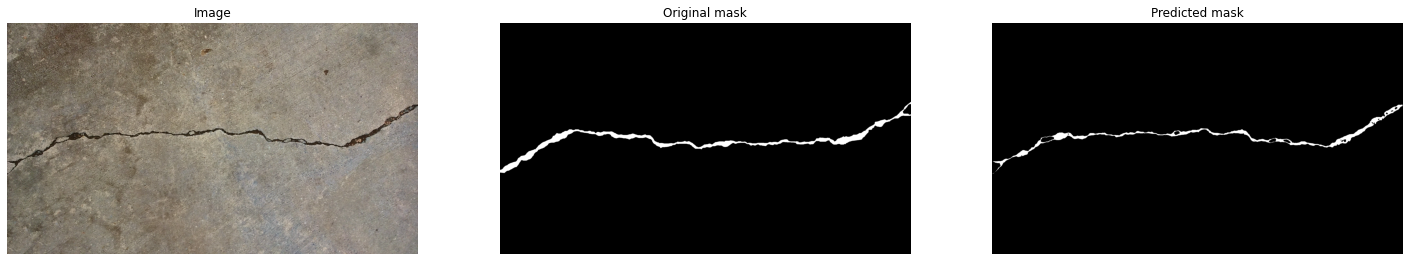

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25,15))

ax[0].set_title("Image")
ax[0].imshow(img.permute(1,2,0).int())
ax[0].axis('off')

ax[1].set_title("Original mask")
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

ax[2].set_title("Predicted mask")
ax[2].imshow(output, cmap='gray')
ax[2].axis('off')

plt.show()

### 새로운 이미지 불러와서 테스트

In [ ]:
image = cv2.imread('/content/101_3e97a465-73e3-49aa-83a7-bb07b009aa7b.jpg')

In [ ]:
transformed = test_transform(image = image)
image = transformed['image'].float()

In [ ]:
new_img = image.unsqueeze(0)

outputs = model(new_img)
output = outputs.argmax(dim=1).squeeze(0) * 255

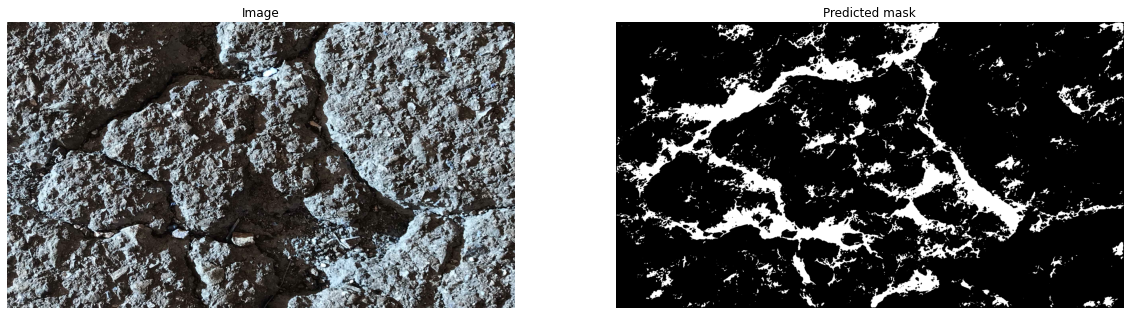

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].set_title("Image")
ax[0].imshow(image.permute(1,2,0).int())
ax[0].axis('off')

ax[1].set_title("Predicted mask")
ax[1].imshow(output, cmap='gray')
ax[1].axis('off')

plt.show()